<a href="https://colab.research.google.com/github/Shashankwer/Tensorflow_Testing/blob/master/NewLayers%26ModelsForKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import tensorflow as tf

Making new layers and Models via Subclassing

## The Layer class: the combination of state (weights) and some computation

Keras the layer class is the center for all the computation. A layer emcapsulates both the state (the "layer's" weight) and the transformation from the inputs to outputs ("call", the layer does the forward pass)

In [2]:
class Linear(tf.keras.layers.Layer):
  def __init__(self,units=32,input_dim = 32):
    super(Linear,self).__init__()
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(initial_value = w_init(shape=(input_dim,units),dtype="float32"),trainable=True)
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(initial_value=b_init(shape=(units),dtype="float32"),trainable=True)

  def call(self,inputs):
    return tf.matmul(inputs,self.w)+self.b

In [3]:
x = tf.ones((2,2))
linear_layer = Linear(4,2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[-0.12226717  0.03650273  0.16900161  0.02193409]
 [-0.12226717  0.03650273  0.16900161  0.02193409]], shape=(2, 4), dtype=float32)


In [4]:
assert linear_layer.weights == [linear_layer.w,linear_layer.b]

In [5]:
linear_layer.weights

[<tf.Variable 'Variable:0' shape=(2, 4) dtype=float32, numpy=
 array([[-0.1118763 ,  0.03389191,  0.02263258, -0.02431311],
        [-0.01039087,  0.00261082,  0.14636903,  0.0462472 ]],
       dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

In [6]:
class Linear(tf.keras.layers.Layer):
  def __init__(self,units=32,input_dim=32):
    super(Linear,self).__init__()
    self.w = self.add_weight(shape=(input_dim,units),dtype="float32",initializer="random_normal",trainable=True)
    self.b = self.add_weight(shape=(input_dim,units),dtype="float32",initializer="zeros",trainable=True)

  def call(self,inputs):
    return tf.matmul(inputs,self.w)+self.b

In [7]:
x = tf.ones((2,2))
linear_layer = Linear(4,2)
y = linear_layer(x)
print(y)


tf.Tensor(
[[-0.02819715 -0.05340973  0.05278432 -0.02962312]
 [-0.02819715 -0.05340973  0.05278432 -0.02962312]], shape=(2, 4), dtype=float32)


### Layers can have non traiable weights: 

Besides trainable weights, one can add non trainable weights to a layer as well. Such weights are meant not to be taken into account during backpropogation

In [8]:
class ComputeSum(tf.keras.layers.Layer):
  def __init__(self,input_dim):
    super(ComputeSum,self).__init__()
    self.total = tf.Variable(initial_value=tf.zeros((input_dim,)),trainable=False)
  
  def call(self,inputs):
    self.total.assign_add(tf.reduce_sum(inputs,axis=0))
    return self.total


In [11]:
x = tf.ones((2,2))
sum = ComputeSum(2)
y = sum(x)
print(y.numpy(),y)
y = sum(x)
print(y.numpy())

[2. 2.] <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2., 2.], dtype=float32)>
[4. 4.]


Its a part of `layer.weights` but it gets categorized as a non trainable weight

In [15]:
print("weights:",len(sum.weights))
print("non-trainable weights:",len(sum.non_trainable_weights))
print("trainable_weight",sum.trainable_weights)

weights: 1
non-trainable weights: 1
trainable_weight []


###  Best practice: deffering weight creation unitl the shape of the inputs is known

Our `Linear` layer above took an `input_dim` argument that was used to compute the shape of the weights `w` and `b` in `__init__()`

In [17]:
class Linear(tf.keras.layers.Layer):
  def __init__(self,units=32,input_dim=32):
    super(Linear,self).__init__()
    self.w = self.add_weight(shape=(input_dim,units),initializer="random_normal",trainable=True)
    self.b = self.add_weight(shape=(units),initializer="zeros",trainable=True)
  
  def call(self,inputs):
    return tf.matmul(inputs,self.w) + self.b

In many cases, one may know in advanced the size of inputs, and one would like to lazily create weights when that value becomes known, some time after instantiating the layer. 

In the Keras API, we recommed creating layer weights in `build(self,nputs_shape)` method of the layer

In [18]:
class Linear(tf.keras.layers.Layer):
  def __init__(self,units=32):
    super(Linear,self).__init__()
    self.units = units

  def build(self,input_shape):
    self.w = self.add_weight(
        shape = (input_shape[-1],self.units),
        initializer = "random_normal",
        trainable=True
    )
    self.b = self.add_weight(
        shape = (self.units,),initializer="random_normal",trainable=True
    )
  def call(self,inputs):
    return tf.matmul(inputs,self.w)+self.b
  
  

The `__call__()` method of the layer will automatically build the first time it is called. 
One now have a layer that's lazy and thus easier to use:

In [19]:
linear_layer = Linear(32)
y = linear_layer(x)

In [20]:
print(y)

tf.Tensor(
[[ 1.1270022e-01  2.1379441e-05 -4.2608008e-04  1.1688566e-02
   1.2485644e-01  5.4375641e-04 -1.3976950e-02  1.1464427e-01
   1.5625777e-02  2.5340907e-02 -2.2924103e-02 -9.9379949e-02
  -3.2719336e-03  7.9196692e-02 -2.2497110e-01  7.1446546e-03
   2.7232654e-03  3.7931837e-04  4.2238288e-02  1.2001923e-01
   4.4987824e-02  9.9435344e-02  8.4922068e-02 -6.5496624e-02
   1.1168520e-01  6.2112134e-02  1.3878196e-01  5.5522025e-03
   1.3552085e-01  6.6318430e-02  7.8515515e-02 -1.1948916e-01]
 [ 1.1270022e-01  2.1379441e-05 -4.2608008e-04  1.1688566e-02
   1.2485644e-01  5.4375641e-04 -1.3976950e-02  1.1464427e-01
   1.5625777e-02  2.5340907e-02 -2.2924103e-02 -9.9379949e-02
  -3.2719336e-03  7.9196692e-02 -2.2497110e-01  7.1446546e-03
   2.7232654e-03  3.7931837e-04  4.2238288e-02  1.2001923e-01
   4.4987824e-02  9.9435344e-02  8.4922068e-02 -6.5496624e-02
   1.1168520e-01  6.2112134e-02  1.3878196e-01  5.5522025e-03
   1.3552085e-01  6.6318430e-02  7.8515515e-02 -1.1948916e

## Layers are recursively composable

If one assign a Layer instance as attribute of another Layer, the outer layer will start tracking the weights of the inner layer. 

We recommend creating such sublayers in the `__init__()` method(since the sublayers will typically have a build method, they will be built when the outer layer gets built)


In [21]:
class MLPBlock(tf.keras.layers.Layer):
  def __init__(self):
    super(MLPBlock,self).__init__()
    self.linear_1 = Linear(32)
    self.linear_2 = Linear(24)
    self.linear_3 = Linear(1)
  
  def call(self,inputs):
    x = self.linear_1(inputs)
    x = tf.nn.relu(x)
    x = self.linear_2(x)
    x = tf.nn.relu(x)
    return self.linear_3(x)

In [22]:
mlp = MLPBlock()
y = mlp(tf.ones(shape=(3,64))) # the first call to the `mlp` will create the weights
print("weights:",len(mlp.weights))
print("trainable weights:",len(mlp.trainable_weights))

weights: 6
trainable weights: 6


### The `add_loss()` method

When writing the `call()` method of a layer, one can create loss tensors that one will want to use later. When writing your training loop. This is doable loop. This is doable by calling `self.add_loss(value)`

In [25]:
#A layer creating active regularization: 

class ActivityRegularizationLayer(tf.keras.layers.Layer):
  def __init__(self,rate=1e-2):
    super(ActivityRegularizationLayer,self).__init__()
    self.rate = rate
  def call(self,inputs):
    self.add_loss(self.rate*tf.reduce_sum(inputs))
    return inputs

These losses(including those created by any inner layer can be retrieved via `layer.losses`. This property is reset at the start of every `call` to the top-level layer, so that `layer.losses` always contains the loss values created during the last forward pass

In [30]:
class OuterLayer(tf.keras.layers.Layer):
  def __init__(self):
    super(OuterLayer,self).__init__()
    self.activity_reg = ActivityRegularizationLayer(1e-2)
  
  def call(self,inputs):
    return self.activity_reg(inputs)

In [31]:
layer = OuterLayer()
assert len(layer.losses)==0 # No losses yet since the layer has never been called

_ = layer(tf.zeros(1,1))
assert len(layer.losses) == 1 #The loss is created



In [35]:
class OuterLayerWithKernelRegularizer(tf.keras.layers.Layer):
  def __init__(self):
    super(OuterLayerWithKernelRegularizer,self).__init__()
    self.dense = tf.keras.layers.Dense(32,kernel_regularizer=tf.keras.regularizers.l2(1e-4))
  
  def call(self,inputs):
    return self.dense(inputs)

layer = OuterLayerWithKernelRegularizer()
_ = layer(tf.zeros((1,1)))

print(layer.losses)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0001536563>]


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

for x_batch_train,y_batch_train in train_dataset:
  with tf.GradientTape() as tape:
    logits = layer(x_batch_train)
    loss_value = loss_fn(y_batch_train,logits)
    loss_value+= sum(model.losses)
  grads = tape.gradient(loss_value,model.trainable_weights)
  optimizer.apply_gradients(zip(grads,model.trainable_weights))

#The losses gets automatically summed using tf.keras.fit()

In [39]:
import numpy as np
inputs = tf.keras.Input(shape=(3,))
outputs = ActivityRegularizationLayer()(inputs)
model = tf.keras.Model(inputs,outputs)

model.compile(optimizer = "adam",loss="mse")
model.fit(np.random.random((2,3)),np.random.random((2,3)))

1/1 [==============================] - 0s 1ms/step - loss: 0.1024


In [43]:
#it is also possible to not pass the loss as the loss associated with a layer is already added in here

model.compile(optimizer="adam")
model.fit(np.random.random((2,3)),np.random.random((2,3)))

1/1 [==============================] - 0s 2ms/step - loss: 0.0327


In [41]:
np.random.random((2,3))

array([[0.82085334, 0.3509551 , 0.56552574],
       [0.96481398, 0.62101046, 0.05420924]])

# The `add_metric()` method:

Similar to `add_loss()`, layers also have an `add_metric()` method for tracking the moving avergage of quantity during training. 

Consider the following layer: a "logistic endpoint" layer. It takes as input predictions and targets, it computes the loss as it targets through `add_loss()` and accuracy through the scalar `add_metric()`

In [68]:
class LogisticEndpoint(tf.keras.layers.Layer):
  def __init__(self,name=None):
    super(LogisticEndpoint,self).__init__(name)
    self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.accuracy_fn = tf.keras.metrics.BinaryAccuracy()
  def call(self,targets,logits,sample_weights=None):
    #to compute the training time loss the loss is added to the self.add_loss()
    loss = self.loss_fn(targets,logits,sample_weights)
    self.add_loss(loss)
    #accuracy as a metric and is added using self.add_metric
    acc =self.accuracy_fn(targets,logits,sample_weights)
    self.add_metric(acc,name="accuracy")
    return tf.nn.softmax(logits)

In [69]:
#metrics are tracked using layers.metric

layer = LogisticEndpoint()

target = tf.ones((2,2))
#logits = tf.random.normal((2,2))
logits =tf.ones((2,2))
y = layer(target,logits)
print("layer.metric",layer.metrics)

layer.metric [<tensorflow.python.keras.metrics.BinaryAccuracy object at 0x7fe12068ed30>]


In [70]:
print("current accuracy value", float(layer.metrics[0].result()))

current accuracy value 1.0


In [71]:
print("current loss value", layer.losses)

current loss value [<tf.Tensor: shape=(), dtype=float32, numpy=0.3132617>]


In [72]:
print(y)

tf.Tensor(
[[0.5 0.5]
 [0.5 0.5]], shape=(2, 2), dtype=float32)


#Enabling serializable on the layer


Using the `get_config()` method for making the function serializable

In [73]:
class Linear(tf.keras.layers.Layer):
  def __init__(self,units=32):
    super(Linear,self).__init__()
    self.units=units
  def build(self,input_shape):
    self.w = self.add_weight(shape=(input_shape[-1],self.units),dtype="float32",initializer="random_normal",trainable=True)
    self.b = self.add_weight(shape=(units,),dtype='int32',init="zeros")
  
  def call(self,inputs):
    return tf.matmul(inputs,self.w)+self.b
  
  def get_config(self):
    return {"units":self.units}

In [74]:
layer = Linear(64)
config = layer.get_config()
print(config)
new_layer = Linear.from_config(config)

{'units': 64}


In [76]:
new_layer.get_config()

{'units': 64}

The `__init__()` method of the base Layer class takes the arguments  name and dtype and the same arguments are passed to the parent class in `__init__()` and to include them in the layer config:

In [80]:
class Linear(tf.keras.layers.Layer):
  def __init__(self,units=32,**kwargs):
    super(Linear,self).__init__(**kwargs)
    self.units = units

  def build(self,input_shape):
    self.w = self.add_weight(shape=(input_shape[-1],self.units),initializer='random_normla',trainable=True)
    self.b = self.add_weight(shape=(self.units),initializer="random_normal",trainable=True)
  
  def call(self,inputs):
    return tf.matmul(inputs,self.w)+self.b
  
  def get_config(self):
    config = super(Linear,self).get_config()
    config.update({"units":self.units})
    return config

In [81]:
x = Linear(64)
print(x.get_config())

{'name': 'linear_9', 'trainable': True, 'dtype': 'float32', 'units': 64}


#Priviledged training argument in call() method:


Some layers, in particular the `BatchNormalization` layer and the `Dropout` layer have different behaviors during the training and inference. For such layers it is standard practice to expose the training boolean value during the built in call() method

By exposing this argument in `call()`, one enable the built in training evaluation loops (`fit()`) to correctly use the layer during training and evaluation

In [83]:
class CustomDropout(tf.keras.layers.Layer):
  def __init__(self,rate,**kwargs):
    super(CustomDroput,self).__init__(**kwargs)
    self.rate=rate
  def call(self,inputs,training=None):
    if training:
      return tf.nn.dropout(inputs,rate=self.rate)
    return inputs

### The priviliege mask method call()

The other privilege method is supported by `call()` in the mask method. 

It is a booloean method used in (RNN) to skip certain timestamp when processing timestamp data

## The `Model class`

The model class has the same evaluation methods like layers layer with following differences: 

1. It exposes the builtin training, evaluating(model.fit(),model.evaluate(),model.predict())
2. It exposes the list of inner layers using `model.layers` property
3.It exposes the saving a serializable API (tf.save, tf.save-weights)

In Summary

1.  A `Layer` encapsulates a state (created in `__init__()` or `build()` and some computation defined in `call()`)
2. Layers can be reusrsively nested to track loss using add_loss() and add_metrics
3. The outer container, the thing that we wish to train is a Model. A  `Model` is just like a training layer with added training and serializable units. 





In [84]:
from tensorflow.keras import layers

class Sampling(layers.Layer):
  """Uses (z_mean,z_log_var) to sample, the vector encoding a digit ."""
  def call(self,inputs):
    z_mean,z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
    return z_mean + tf.exp(0.5* z_log_var) * epsilon
    

In [87]:
class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean,z_log_var,z)"""

  def __init__(self,latent_dim=32,intermediate_dim=64,name="encoder",**kwargs):
    super(Encoder,self).__init__(name=name,**kwargs)
    self.dense_proj = layers.Dense(intermediate_dim,activation="relu")
    self.dense_mean = layers.Dense(latent_dim)
    self.dense_log_var = layers.Dense(latent_dim)
    self.sampling = Sampling()
  
  def call(self,inputs):
    x = self.dense_proj(inputs)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean,z_log_var))
    return z_mean,z_log_var,z

class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""
  def __init__(self,original_dim,intermediate_dim=64,name="decoder",**kwargs):
    super(Decoder,self).__init__(name=name,**kwargs)
    self.dense_proj = layers.Dense(intermediate_dim,activation="relu")
    self.dense_output = layers.Dense(original_dim,activation="sigmoid")
  
  def call(self,inputs):
    x = self.dense_proj(inputs)
    return self.dense_output(x)

In [88]:
class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end to end model for training."""
  def __init__(self,original_dim,intermediate_dim=64,latent_dim=32,name="autoencoder",**kwargs):
    super(VariationalAutoEncoder,self).__init__(name=name,**kwargs)
    self.original_dim=original_dim
    self.encoder = Encoder(latent_dim = latent_dim,intermediate_dim=intermediate_dim)
    self.decoder = Decoder(original_dim,intermediate_dim=intermediate_dim)
  def call(self,inputs):
    z_mean,z_log_var,z = self.encoder(inputs)
    reconstructed = self.decoder(z)
    #Add KL divergence regularization loss. 
    kl_loss = -0.5* tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var)+1)
    self.add_loss(kl_loss)
    return reconstructed

In [103]:
original_dim = 784
vae = VariationalAutoEncoder(original_dim,64,32)
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()
(x_train,_),_ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000,784).astype("float32")/255
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

epochs=2

for epoch in range(epochs):
  print("Start of epoch %d"%(epoch,))

  for step,x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)
      loss = mse_loss_fn(x_batch_train,reconstructed)
      #print(loss,sum(vae.losses))
      loss+=vae.losses[0] # adding the KLD regularization loss
    
    grads =tape.gradient(loss,vae.trainable_weights)
    optimizer.apply_gradients(zip(grads,vae.trainable_weights))
    loss_metric(loss)
    if step%100==0:
      print("step %d: mean loss = %.4f"%(step,loss_metric.result()))

Start of epoch 0
step 0: mean loss = 0.3259
step 100: mean loss = 0.1268
step 200: mean loss = 0.1002
step 300: mean loss = 0.0900
step 400: mean loss = 0.0849
step 500: mean loss = 0.0818
step 600: mean loss = 0.0793
step 700: mean loss = 0.0779
step 800: mean loss = 0.0767
step 900: mean loss = 0.0758
step 1000: mean loss = 0.0748
step 1100: mean loss = 0.0741
step 1200: mean loss = 0.0736
step 1300: mean loss = 0.0732
step 1400: mean loss = 0.0727
step 1500: mean loss = 0.0724
step 1600: mean loss = 0.0721
step 1700: mean loss = 0.0718
step 1800: mean loss = 0.0715
Start of epoch 1
step 0: mean loss = 0.0713
step 100: mean loss = 0.0711
step 200: mean loss = 0.0710
step 300: mean loss = 0.0708
step 400: mean loss = 0.0707
step 500: mean loss = 0.0706
step 600: mean loss = 0.0705
step 700: mean loss = 0.0704
step 800: mean loss = 0.0703
step 900: mean loss = 0.0702
step 1000: mean loss = 0.0701
step 1100: mean loss = 0.0700
step 1200: mean loss = 0.0699
step 1300: mean loss = 0.0699


In [105]:
vae = VariationalAutoEncoder(784,64,32)
optimizeer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer,loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train,x_train,epochs=2,batch_size=32)

Epoch 1/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0685
Epoch 2/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0675


In [144]:
original_dim =784
intermediate_dim =256
latent_dim = 128

original_inputs = tf.keras.Input(shape=(original_dim,),name="encoder_input")
x = layers.Dense(intermediate_dim,activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim,name="z_mean")(x)
z_log_var = layers.Dense(latent_dim,name="z_log_var")(x)
z = Sampling()((z_mean,z_log_var))
encoder = tf.keras.Model(inputs=original_inputs,outputs=z,name="encoder")
#Define the decoder model

latent_inputs = tf.keras.Input(shape=(latent_dim,),name="z_sampling")
x = layers.Dense(intermediate_dim,activation="relu")(latent_inputs)
x = layers.Dense(original_dim,activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs,outputs=x,name="decoder")

#Defining the VAE model

outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs,outputs=outputs,name="vae")
kl_loss = -0.5 * tf.reduce_sum(z_log_var-tf.square(z_mean)-tf.exp(z_log_var)+1)
vae.add_loss(kl_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train,x_train,epochs=10,batch_size=32)



Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5793
Epoch 2/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0681
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0678
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0677
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0677
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0676
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0676
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0676
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0675
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0675


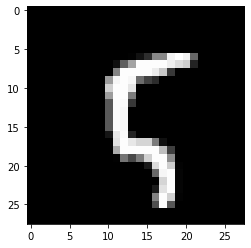

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_train[100].reshape(28,28),cmap="gray")

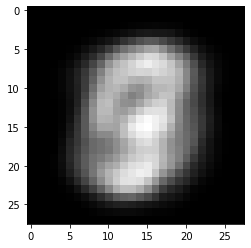

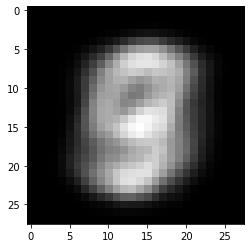

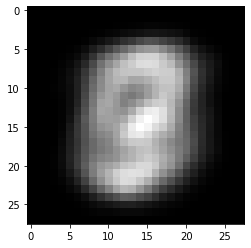

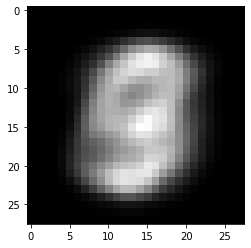

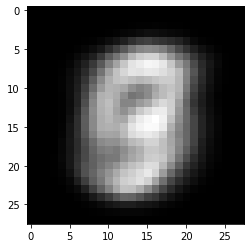

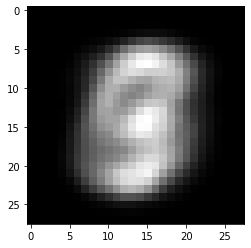

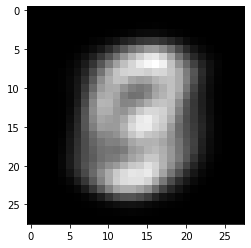

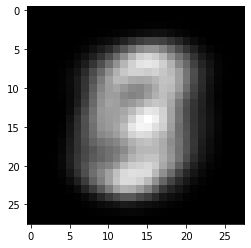

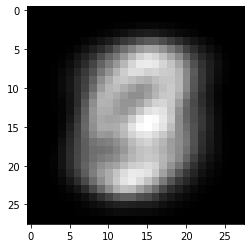

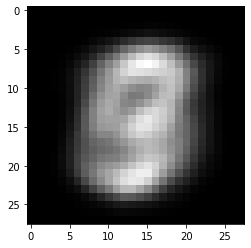

In [147]:
for _ in range(10):
  j = np.random.randint(1,60000)
  plt.imshow(vae.predict(x_train[j].reshape(1,784)).reshape(28,28),cmap="gray")
  plt.show()